<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/corncomp_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌽 It's Corn Starter 🌽

- Using Jeremy Howard's [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) as a guide lets build a quick starter model to iterate upon!
- Highly reccomend giving senpai Jeremy a follow he is the goat!




**Content:**
1. [Image EDA](#1)
1. [DataLoader](#2)
1. [Model](#3)
1. [Submission](#4)


In [ ]:
!pip install kaggle fastkaggle fastai timm>=0.6.2.dev0 

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

In [ ]:
from fastkaggle import * 

comp = 'kaggle-pog-series-s01e03'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 491M/491M [00:04<00:00, 107MB/s]


In [ ]:
 from pathlib import Path
path = Path('/content/kaggle-pog-series-s01e03/corn/')
path

Path('/content/kaggle-pog-series-s01e03/corn')

In [ ]:
from fastai.vision.all import *

path.ls()

(#5) [Path('/content/kaggle-pog-series-s01e03/corn/train'),Path('/content/kaggle-pog-series-s01e03/corn/test.csv'),Path('/content/kaggle-pog-series-s01e03/corn/test'),Path('/content/kaggle-pog-series-s01e03/corn/sample_submission.csv'),Path('/content/kaggle-pog-series-s01e03/corn/train.csv')]

In [ ]:
trn_path = path/'train'
files = get_image_files(trn_path)
files

(#14322) [Path('/content/kaggle-pog-series-s01e03/corn/train/10746.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/13148.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/09864.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/16717.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/03403.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/12403.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/11781.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/10775.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/11120.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/04426.png')...]

In [ ]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14322 entries, 0 to 14321
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   seed_id  14322 non-null  int64 
 1   view     14322 non-null  object
 2   image    14322 non-null  object
 3   label    14322 non-null  object
dtypes: int64(1), object(3)
memory usage: 447.7+ KB


<a id="1"></a> <br>
### Lets check out our images

(132, 124)


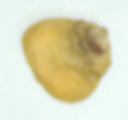

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like these images are 160 x 168 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's parallel for this.

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(140, 136)    187
(132, 132)    187
(136, 132)    168
(136, 136)    166
(128, 132)    165
             ... 
(107, 124)      1
(140, 139)      1
(216, 124)      1
(184, 176)      1
(144, 92)       1
Length: 784, dtype: int64

Looks like a lot of our images vary in size, lets resize each image to a common dimension size or it will be hard to create batches. 

<a id="2"></a> <br>
### DataLoader
We'll use ImageDataLoader.from_csv method and pass our train.csv to grab the labels for each corresponding image

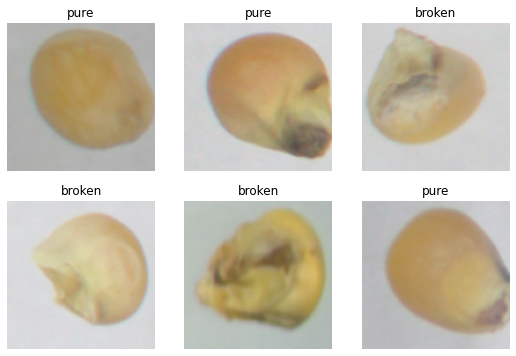

In [ ]:
dls = ImageDataLoaders.from_csv(path, 'train.csv', fn_col=2, label_col=3, item_tfms=Resize(132, method='squish'),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

<a id="1"></a> <br>
### Now lets create our first model!
- Used this [notebooks](https://www.kaggle.com/code/kurianbenoy/fastai-baseline-it-s-corn) reccomendation for convnext_nano, metrics and number of epochs, check it out.

In [ ]:
learn = vision_learner(dls, 'convnext_nano', metrics=[accuracy, Recall(average='weighted')])

SuggestedLRs(valley=0.0008317637839354575, slide=0.0014454397605732083)

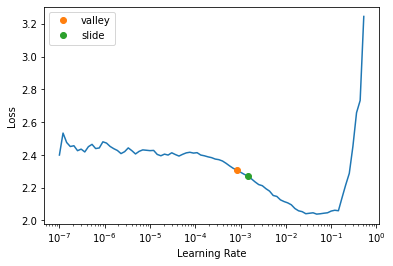

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

### Lets train our notebook for 5 epochs

In [ ]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.081572,0.054044,0.982193,0.982193,21:02


epoch,train_loss,valid_loss,accuracy,recall_score,time


In [ ]:
learn.show_results()

In [ ]:
interpretation = Interpretation.from_learner(learn)

In [ ]:
interpretation.plot_top_losses(9, figsize=(15,10))

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss = ss['seed_id']
tst_df = pd.read_csv(path/'test.csv')
tst_df
ss

,seed_id,label
0,8632,broken
1,11394,broken
2,17362,pure
3,9987,discolored
4,17226,silkcut
...,...,...
3474,1461,pure
3475,2566,discolored
3476,11504,discolored
3477,5140,pure


In [ ]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files)

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([2, 2, 2,  ..., 2, 2, 2])

In [ ]:
dls.vocab

['broken', 'discolored', 'pure', 'silkcut']

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
tst_df['label'] = results
tst_df

0             pure
1             pure
2             pure
3           broken
4           broken
           ...    
3474    discolored
3475        broken
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

In [ ]:
ss = pd.merge(ss, tst_df, on="seed_id")
ss

In [ ]:
ss = ss[["seed_id", "label"]]
ss

In [ ]:
ss['label'] = results
ss.to_csv('submission.csv', index=False)
!head submission.csv

seed_id,label
8632,pure
11394,pure
17362,pure
9987,broken
17226,broken
17100,pure
968,pure
4069,pure
8505,broken


In [ ]:
from kaggle import api
api.competition_submit_cli('submission.csv', 'initial convnext_nano', comp)

100%|██████████| 41.5k/41.5k [00:02<00:00, 20.4kB/s]


Successfully submitted to It's Corn (PogChamps #3)

### Lots of room for improvement, but good to get a model going and submission now to iterate!

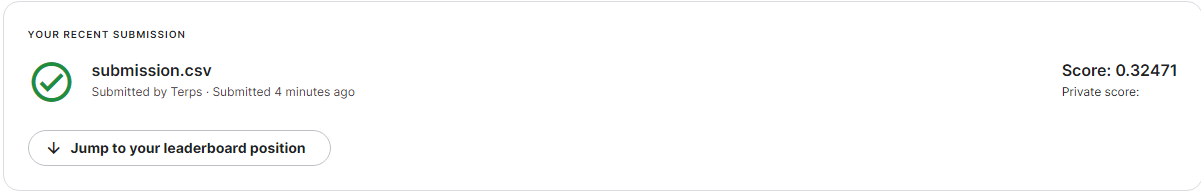

To-do:
- Flip rotate/flip images so view column is same for each picture
- Proper labels for each photo ✅
- Test more models 